# <center> Gender Biais detection</center>
## <center> A first approach from the Bolukbasi Paper </center>
### <center> Quillivic Robin </center>
Sources : Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings, Bolukbasi, Tolga, 2016


In [1]:
from gensim import *
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
import logging
import gensim
import os

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from random import *

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import lib
from sklearn import preprocessing
import itertools

C:\Users\Robin\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## DATA
We load two differents models, first one was cosntructed with Word2vec, Second one using  FastText.

In [2]:
# Logging code taken from http://rare-technologies.com/word2vec-tutorial/
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\GoogleNews-vectors-negative300.bin', binary=True,limit=50000)
model_ff = gensim.models.KeyedVectors.load_word2vec_format(r'DATA\ENG\crawl-300d-2M.vec', binary=False,limit=50000)

# normalizeation :
model.init_sims(True)

2019-03-21 17:37:50,881 : INFO : loading projection weights from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-03-21 17:37:51,573 : INFO : loaded (50000, 300) matrix from DATA\ENG\GoogleNews-vectors-negative300.bin
2019-03-21 17:37:51,574 : INFO : loading projection weights from DATA\ENG\crawl-300d-2M.vec
2019-03-21 17:38:05,543 : INFO : loaded (50000, 300) matrix from DATA\ENG\crawl-300d-2M.vec
2019-03-21 17:38:05,544 : INFO : precomputing L2-norms of word weight vectors


## 1) Direct Biais
We will start by computing the direct biais of a corpus. for this reason, we have to :
* Select pair of word, that represent the idea of Gender
* Constructu the subspace associated with this direction
* Cosntruct a direction assocated with this subspace

#### 1) Gender pairs
Here is tow set of pairs associated with the Gender idea,
* Gender_pair_10, is the one used in Bolukbasi
* Gender_pair is another one from me.

In [3]:
Gender_Pair_10 = [['she','he'],['woman','man'],['her','his'],['herself','himself'],['daughter','son'],
               ['mother','father'],['sister','brother'],['female','male'],['girl','boy'],['gal','guy']]

#### 2) Subspace and direction
In this section we build the function we need to construct the gender direction. We develop 2 methods here :
* from_pair_to_direction0 : This is the most naive approch, we took the pairs (a,b) and compute the subspace with b-a vectors. Then apply a PCA with n_c = number of pairs/2
* from_pair_to_direction1 : that took a subspace build using all pairs (a,b) with (b-a) and (a-b) into the matrix of subspace and apply a PCA of n_c= numbre of pairs
* from_pair_to_direction2 :  took a subspace build using all pairs (a,b) and compute center  =(b-a)/2 and then add to the subspace matrix a-center and b-center  and apply a PCA of n_c= numbre of pairs
               

In [4]:
def normalized(x):
    if np.linalg.norm(x)==0:
        x_norm = x
    else :
        x_norm =x/np.linalg.norm(x)
    return(x_norm)
    

def create_random_pair(n,model):
    """
    Function that creates n random pairs of word, using the model of Google news
    Entry: 
    - n: type:int Nunber of pair needed
    Output: 
    - Pair: type:List ; list of pair size: nx2
    """
    df = pd.DataFrame(list(model.vocab.items()), columns=['word','count'])
    list_word = list(df['word'])
    shuffle(list_word)
    
    Pair=[]
    for i in range(n):
        Pair.append([list_word[i],list_word[2*i]])
    return(Pair)


def from_pair_to_direction0(Pair,model):
    """
    Extraction of the  principale component  of the subspace created from the differences of word pair with
    with the vector b-a
     Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    - model: type:GensimModel
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    SubS = []
    for a, b in Pair:
        SubS.append(model[a] - model[b] )
    SubS= np.array(SubS)
    n_c =int(len(Pair)/2 )
    #print('the dim initial is',len(SubS[0]))
    # Now we are doinf a PCA
    pca = PCA(n_components=n_c)
    pca.fit(SubS)
    Y_pca = pca.fit_transform(SubS)
    eig_values = pca.singular_values_
    expl_var = pca.explained_variance_ratio_
    direction = pca.components_[0]
    return(direction, expl_var,eig_values)


def from_pair_to_direction1(Pair,model):
    """
    Extraction of the  principale component  of the subspace created from the differences of word pair with
    with the vector b-a,a-b
     Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    - model: type:GensimModel
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    SubS = []
    for a, b in Pair:
        SubS.append(model[a] - model[b] )
        SubS.append(model[b] - model[a] )
    SubS= np.array(SubS)
    n_c =len(Pair) 
    #print('the dim initial is',len(SubS[0]))
    # Now we are doinf a PCA
    pca = PCA(n_components=n_c)
    pca.fit(SubS)
    Y_pca = pca.fit_transform(SubS)
    eig_values = pca.singular_values_
    expl_var = pca.explained_variance_ratio_
    direction = pca.components_[0]
    return(direction, expl_var,eig_values)



def from_pair_to_direction2(Pair, model):
    """
    Extraction of the  principale component  of the subspace created from the differences of word pair with
    with the vector b-center,a-center
     Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    - model: type:GensimModel
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    num_components = len(Pair)
    matrix = []
    for a, b in Pair:
        center = (model[a] + model[b])/2
        matrix.append(model[a] - center)
        matrix.append(model[b] - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    eig_values = pca.singular_values_
    expl_var = pca.explained_variance_ratio_
    direction = pca.components_[0]
    return(direction, expl_var,eig_values)


def plot_var_eig(eig_values,expl_var):
    """
    plot the explained variance and theeigen values of the  pca
    """
    plt.figure(figsize = (20,10))
    plt.subplot(121)
    plt.bar(np.arange(len(eig_values)),eig_values)
    plt.title('The eigen values for the subspace',fontsize=18)
    
    ##
    plt.subplot(122)
    plt.bar(np.arange(len(expl_var)),expl_var)
    plt.title('The variance explained by each of the selected components',fontsize=18)
    plt.show()
        

In [5]:
n=10
#zero method
direction_g0, expl_var_g0,eig_values_g0 = from_pair_to_direction0(Gender_Pair_10, model)
## Random pairs 1
direction_r0, expl_var_r0,eig_values_r0 = from_pair_to_direction0( create_random_pair(n,model),model)
# fist method
direction_g1, expl_var_g1,eig_values_g1 = from_pair_to_direction1(Gender_Pair_10, model)
## Random pairs 1
direction_r1, expl_var_r1,eig_values_r1 = from_pair_to_direction1( create_random_pair(n,model),model)
# second method
direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Gender_Pair_10,model)
## Random pairs 2
direction_r2, expl_var_r2,eig_values_r2 = from_pair_to_direction2(create_random_pair(n,model),model)


##### 2.1 plot the componant of the PCA for the 2 methods

####################
#  Model 0, Gender #
####################


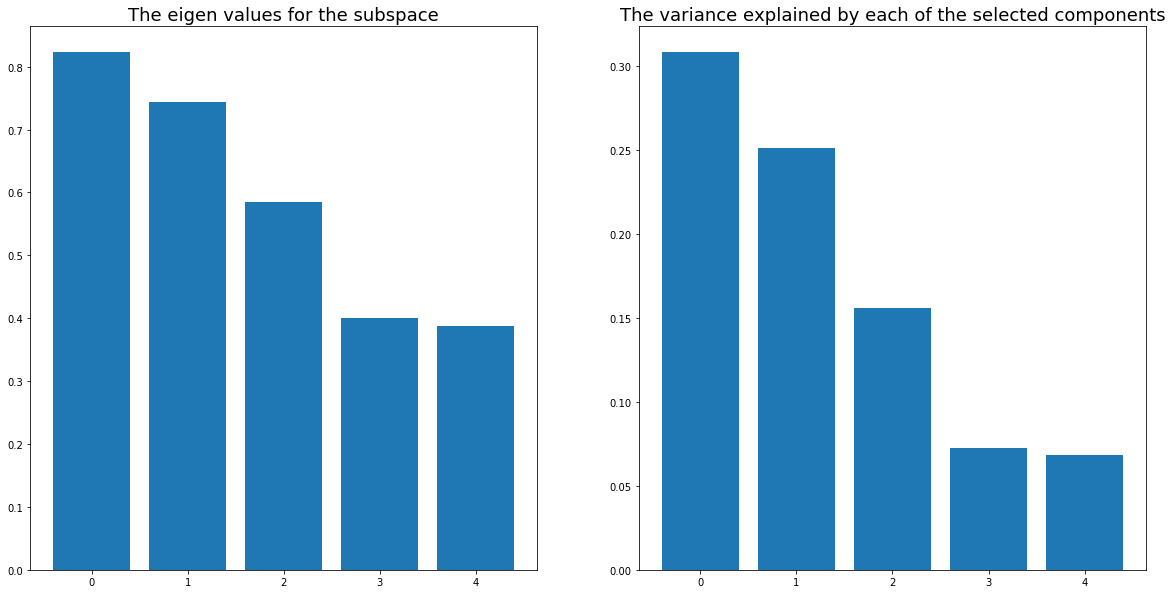

In [6]:
print('####################')
print('#  Model 0, Gender #')
print('####################')     
plot_var_eig(eig_values_g0,expl_var_g0)

####################
#  Model 1, Gender #
####################


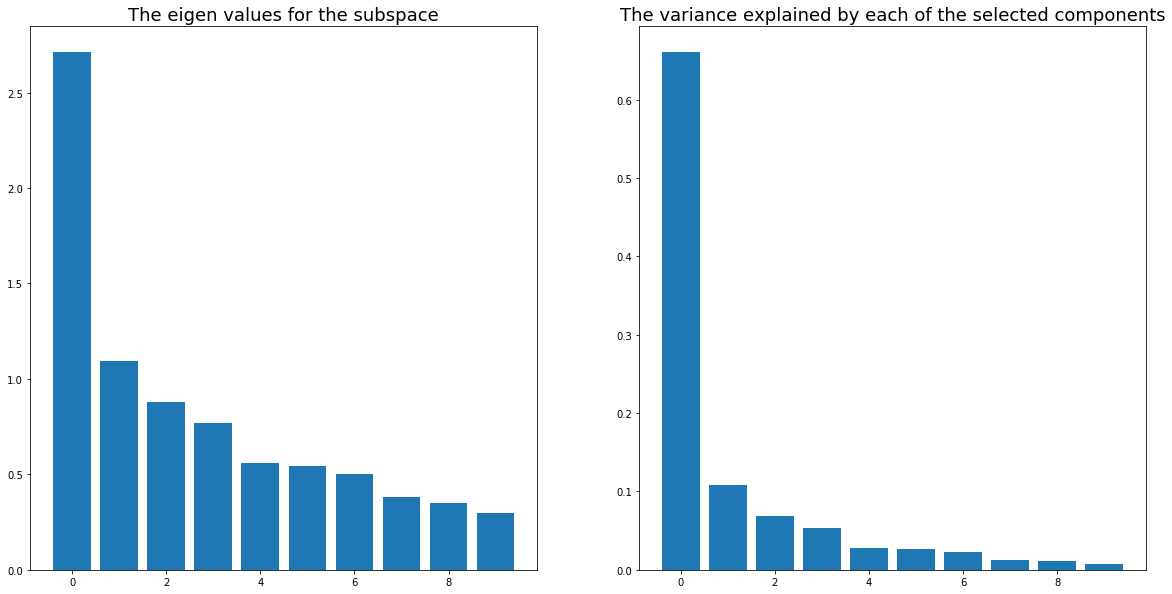

In [7]:
print('####################')
print('#  Model 1, Gender #')
print('####################')     
plot_var_eig(eig_values_g1,expl_var_g1)

####################
#  Model 2, Gender #
####################


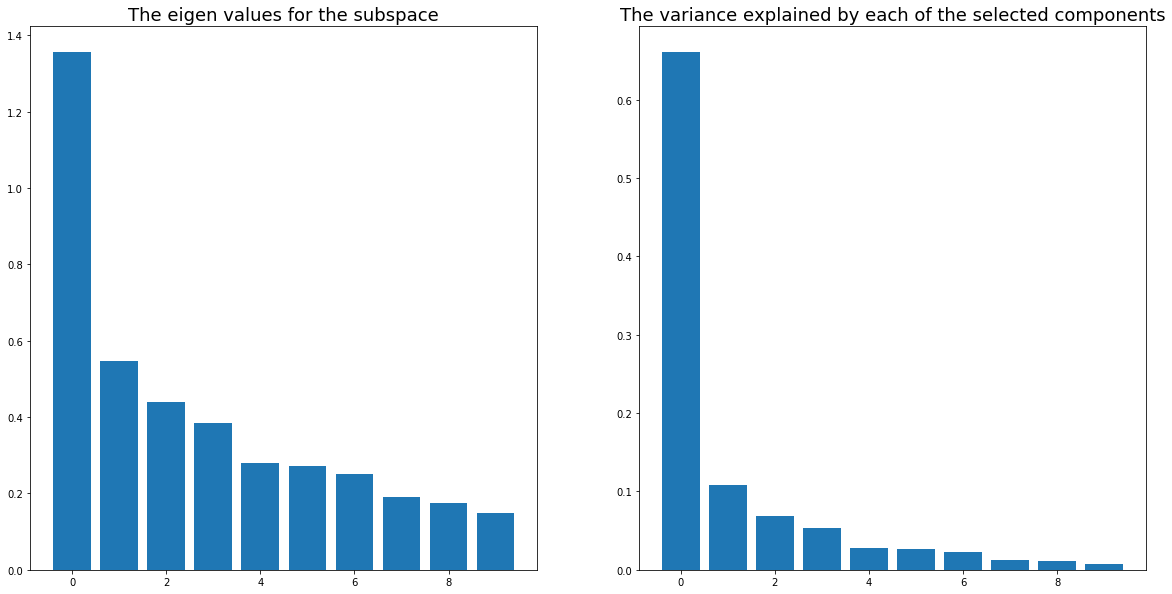

In [8]:
print('####################')
print('#  Model 2, Gender #')
print('####################')     
plot_var_eig(eig_values_g2,expl_var_g2)

####################
#  Model 0, Random #
####################


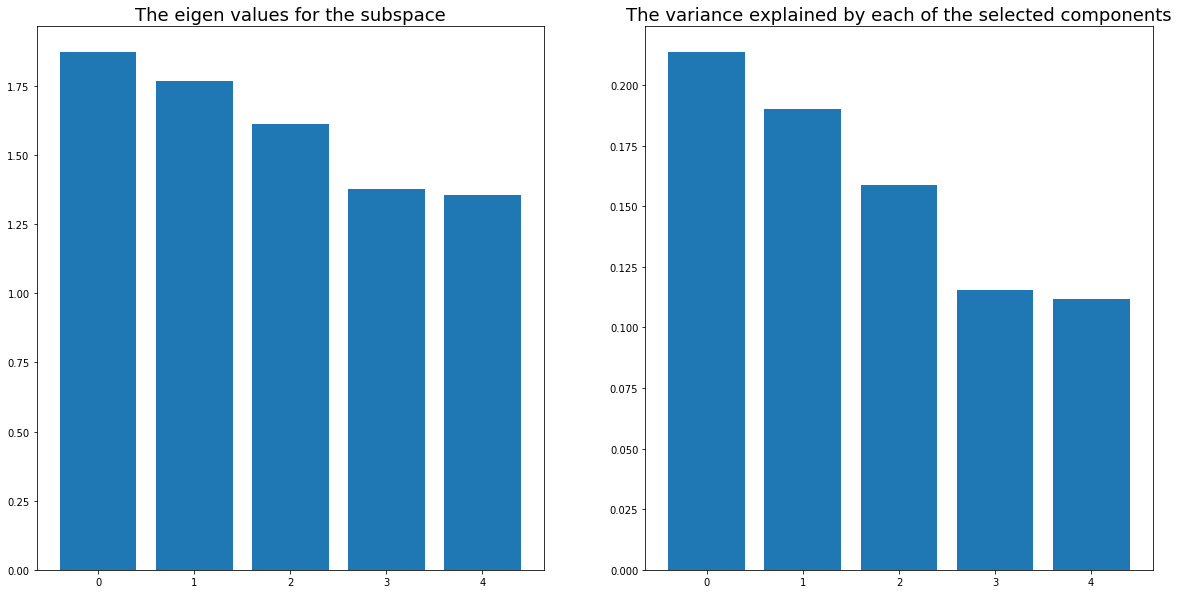

In [9]:
print('####################')
print('#  Model 0, Random #')
print('####################')     
plot_var_eig(eig_values_r0,expl_var_r0)

####################
#  Model 1, Random #
####################


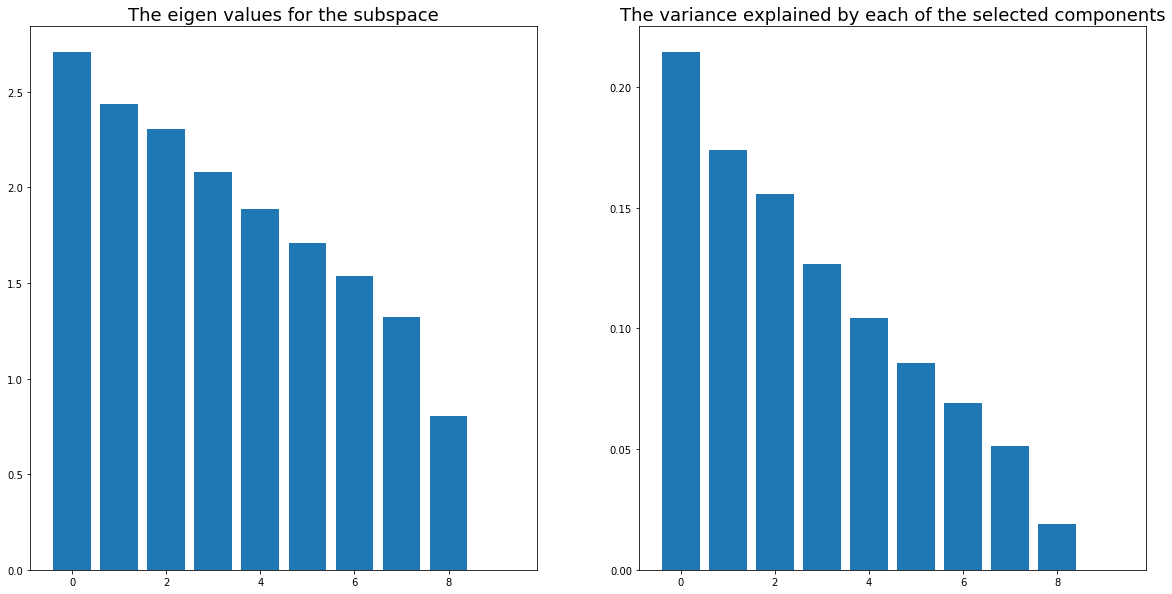

In [10]:
print('####################')
print('#  Model 1, Random #')
print('####################')     
plot_var_eig(eig_values_r1,expl_var_r1)

####################
#  Model 2, Random #
####################


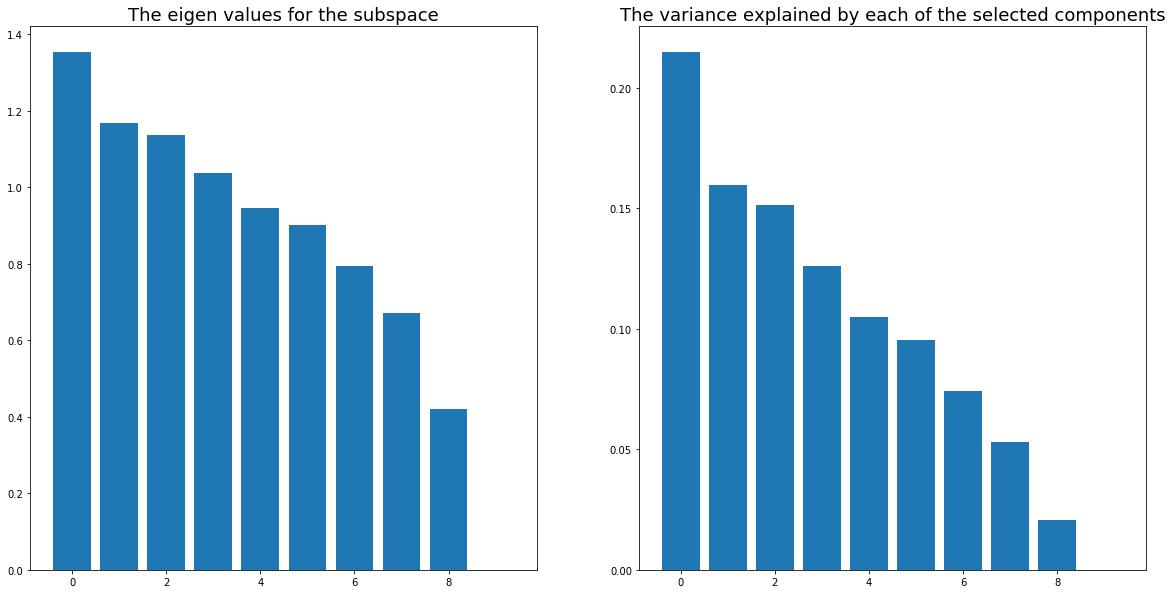

In [11]:
print('####################')
print('#  Model 2, Random #')
print('####################')     
plot_var_eig(eig_values_r2,expl_var_r2)

##### 2.2 plot the componant of the PCA for the mean of 1000 random pairs 

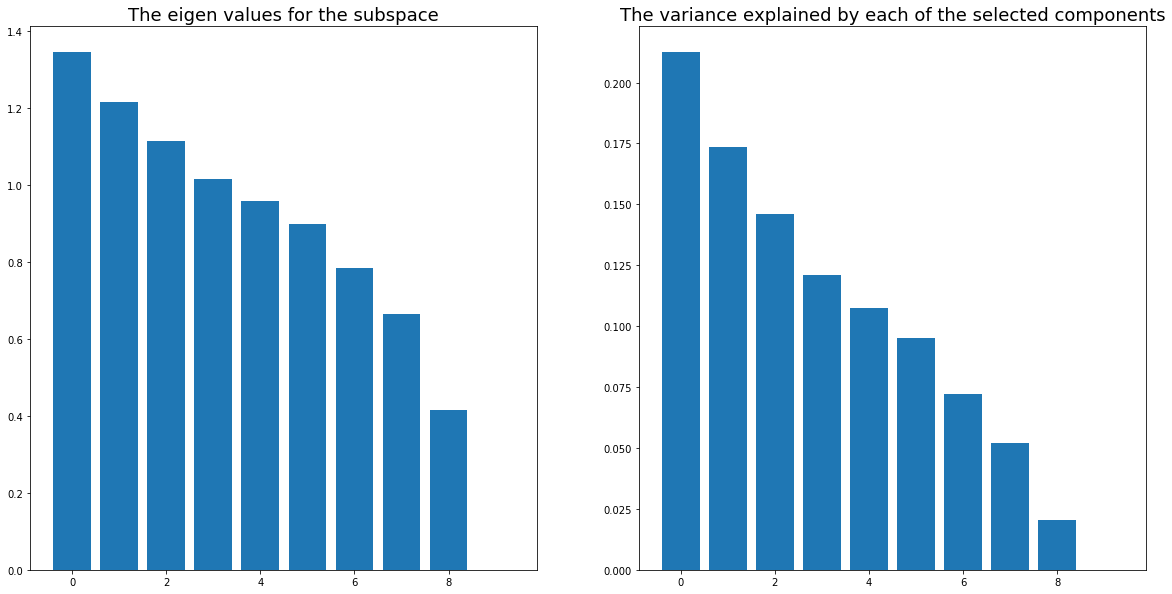

In [12]:
def plot_mean(n,model) :
    Rand_var =[]
    Rand_eig  = []
    for i in range(n):
        direction_r2, expl_var_r2,eig_values_r2 = from_pair_to_direction2(create_random_pair(10,model),model)
        Rand_var.append(expl_var_r2)
        Rand_eig.append(eig_values_r2)
    return(Rand_var,Rand_eig)

Rand_var,Rand_eig = plot_mean(1000,model)
plot_var_eig(np.asarray(Rand_eig).mean(axis=0) , np.asarray(Rand_var).mean(axis=0))
    

##### 2.3 Example of direct Biais

In [12]:
word =['table','apple','engineer','woman','student','art',
       'mathematics','music','football','skirt','love',
       'amazing','house','adventure','brother',
       'army','violin','game','win','softball','dream',
       'success','family','joy','child','time','president'
      ]

In [13]:
def example(Gender_Pair,model,word):
    direction_g1, expl_var_g1,eig_values_g1 = from_pair_to_direction1(Gender_Pair, model)
    direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Gender_Pair, model)
    direction_g0, expl_var_g0,eig_values_g0 = from_pair_to_direction0(Gender_Pair, model)
    ZERRO=[]
    UN=[]
    DEUX = []
    for w in word :
        ZERRO.append(lib.cosine_similarity(direction_g0,model[w])*100)
        UN.append(lib.cosine_similarity(direction_g1,model[w])*100)
        DEUX.append(lib.cosine_similarity(direction_g2,model[w])*100)
    ex = pd.DataFrame(data={'Biais méthode 0':ZERRO,'Biais methode 1':UN,'Biais méthode 2': DEUX},index=word)
    return(ex)
example(Gender_Pair_10,model,word)

,Biais méthode 0,Biais methode 1,Biais méthode 2
table,-10.093930,0.041502,0.041501
apple,4.256014,1.291909,1.291908
engineer,4.009095,-11.437272,-11.437271
woman,8.362655,33.136111,33.136111
student,-2.474253,10.851130,10.851127
art,0.834002,6.592824,6.592824
mathematics,-6.102662,-0.736503,-0.736503
music,6.424332,4.245131,4.245131
football,-18.631767,-21.507448,-21.507446
skirt,11.540688,25.548887,25.548887


In [14]:
print('the cosine similarity between the direction 0 and 1 is : ',lib.cosine_similarity(direction_g0,direction_g1))
print('the cosine similarity between the direction 0 and 2 is : ',lib.cosine_similarity(direction_g0,direction_g2))
print('the cosine similarity between the direction 1 and 2 is : ',lib.cosine_similarity(direction_g1,direction_g2))

the cosine similarity between the direction 0 and 1 is :  0.592855
the cosine similarity between the direction 0 and 2 is :  0.592855
the cosine similarity between the direction 1 and 2 is :  1.0000001


### Comment :
As expected, the  methods 1 and 2 are quite the same. However, the methode zerro is reaaly different. We have to understand why...

**Both fastText and W2V are common crawl web model. So we hope the biais observe are quite similar.Indeed, the gender biais should be representing the same way, because they are the traduction of the same reality.**

In [15]:
def example_model(Gender_Pair,model,word):
    direction_g, expl_var_g,eig_values_g = from_pair_to_direction2(Gender_Pair, model)
    direction_g_ff, expl_var_g_ff,eig_values_g_ff = from_pair_to_direction2(Gender_Pair, model_ff)
    W= []
    F=[]
    DEUX = []
    for w in word :
        W.append(lib.cosine_similarity(direction_g,model[w])*100)
        F.append(lib.cosine_similarity(direction_g_ff,model_ff[w])*100)
        
    ex = pd.DataFrame(data={'Biais W2V corpus':W,'Biais Fast_Text':F},index=word)
    ex['diff'] = abs(ex['Biais W2V corpus']-ex['Biais Fast_Text'])
    return(ex)
example_model(Gender_Pair_10,model,word)

,Biais W2V corpus,Biais Fast_Text,diff
table,0.041501,2.893366,2.851865
apple,1.291908,1.780889,0.488981
engineer,-11.437271,-10.537615,0.899656
woman,33.136111,33.448818,0.312707
student,10.851127,3.449088,7.402039
art,6.592824,4.262571,2.330253
mathematics,-0.736503,-2.349531,1.613029
music,4.245131,-2.699578,6.944709
football,-21.507446,-14.179164,7.328282
skirt,25.548887,20.457728,5.091159


In [16]:
direction_g, expl_var_g,eig_values_g = from_pair_to_direction2(Gender_Pair_10, model)
direction_g_ff, expl_var_g_ff,eig_values_g_ff = from_pair_to_direction2(Gender_Pair_10, model_ff)
print('the cosine similarity between the direction W2V and FF is : ',lib.cosine_similarity(direction_g,direction_g_ff))

the cosine similarity between the direction W2V and FF is :  -0.01001374


In [17]:
def example_pairs(Gender_Pair1,Gender_Pair2,model,word):
    direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Gender_Pair2, model)
    direction_g1, expl_var_g1,eig_values_g1 = from_pair_to_direction2(Gender_Pair1, model)
    U= []
    D=[]
    for w in word :
        U.append(lib.cosine_similarity(direction_g1,model[w])*100)
        D.append(lib.cosine_similarity(direction_g2,model[w])*100)
        
    ex = pd.DataFrame(data={'Biais with pair 1':U,'Biais with pair 2':D},index=word)
    ex['diff'] = abs(ex['Biais with pair 1']-ex['Biais with pair 2'])
    return(ex)
#
Gender_Pair = [['she','he'],['woman','man'],['her','his'],['Mary','John'],['herself','himself'],['daughter','son'],
               ['mother','father'],['gal','guy'],['sister','brother'],['female','male'],['girl','boy'], ['spokeswoman','spokesman'],
              ['stepmother','stepfather'],['queen','king'],['actress','actor'],
               ['girlfriend','boyfriend' ],['twin_sister','twin_brother']]

Gender_Pair = [['she','he'],['woman','man'],
               ['her','his'],['Mary','John'],
               ['herself','himself'],['daughter','son'],
               ['mother','father'],['gal','guy'],
               ['sister','brother'],#['female','male'],
               ['girl','boy'], ['spokeswoman','spokesman'],
               ['stepmother','stepfather'],['queen','king'],
               ['actress','actor'],['girlfriend','boyfriend' ],
               ['twin_sister','twin_brother']]

example_pairs(Gender_Pair_10,Gender_Pair,model,word)

,Biais with pair 1,Biais with pair 2,diff
table,0.041501,-1.049367,1.090868
apple,1.291908,-0.905184,2.197092
engineer,-11.437271,13.455410,24.892681
woman,33.136111,-32.101068,65.237179
student,10.851127,-9.208173,20.059300
art,6.592824,-7.197586,13.790410
mathematics,-0.736503,0.080576,0.817079
music,4.245131,-3.368367,7.613498
football,-21.507446,18.752886,40.260333
skirt,25.548887,-24.972324,50.521211


In [18]:
Gender_Pair2 = [['she','he'],['woman','man'],['her','his'],['herself','himself'],['daughter','son'],
                ['spokeswoman','spokesman'],['stepmother','stepfather'],['actress','actor'],
                ['waitress','waiter'],['twin_sister','twin_brother']]

example_pairs(Gender_Pair,Gender_Pair_10,model,word)

,Biais with pair 1,Biais with pair 2,diff
table,-1.049367,0.041501,1.090868
apple,-0.905184,1.291908,2.197092
engineer,13.455410,-11.437271,24.892681
woman,-32.101068,33.136111,65.237179
student,-9.208173,10.851127,20.059300
art,-7.197586,6.592824,13.790410
mathematics,0.080576,-0.736503,0.817079
music,-3.368367,4.245131,7.613498
football,18.752886,-21.507446,40.260333
skirt,-24.972324,25.548887,50.521211


##### 2.4 Direct Biais of one corpus

In [19]:
def Direct_Biais(corpus, Pair, model):
    direction_g, expl_var_g,eig_values_g = from_pair_to_direction2(Pair, model)
    B=[]
    for word in corpus :
        B.append(lib.cosine_similarity(direction_g,model[word]))
    df_B = pd.DataFrame(data={'Direct Biais':B})
    
    return(df_B,df_B['Direct Biais'].mean())

df_B,m  = Direct_Biais(list(model.vocab), Gender_Pair_10, model)
print('The direct biais od the 50000 word in the W2V corpus is ',m)
df_B_ff,m_ff = Direct_Biais(list(model_ff.vocab), Gender_Pair_10, model_ff)
print('The direct biais od the 50000 word in the FastText corpus is ',m_ff)

The direct biais od the 50000 word in the W2V corpus is  -0.0007466879721125486
The direct biais od the 50000 word in the FastText corpus is  0.00761893258211167


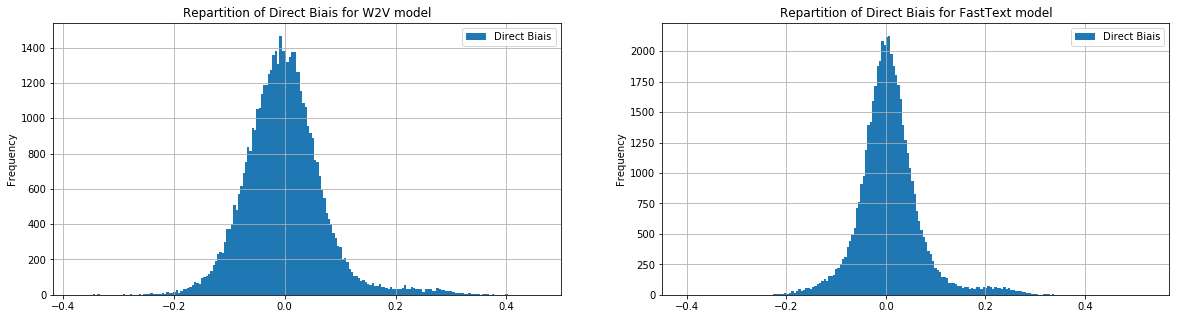

In [20]:

plt.figure(figsize=(20,5))
plt.subplot(121)
df_B.plot(kind='hist',bins = 200,ax=plt.gca(),grid=True)
plt.title('Repartition of Direct Biais for W2V model')
plt.subplot(122)
df_B_ff.plot(kind='hist',bins = 200,ax=plt.gca(),grid=True)
plt.title('Repartition of Direct Biais for FastText model')
plt.show()

### Evaluate the contribution of each pair  to the PCA

In [4]:
def from_pair_to_contribution(Pair, model):
    """
    Extraction of the contribution of each component for a pair of word in PCA
     Entry:
    - Pair: type:List  size:nx2 ; list of pair word
    - model: type:GensimModel
    Output:
    - direction : principal component of the PCA
    - expl_var : explained_variance_ratio_ of the pca
    - eig_values: eig_values of the pca
    """
    num_components = len(Pair)
    matrix = []
    label = []
    for a, b in Pair:
        center = (model[a] + model[b])/2
        matrix.append(model[a] - center)
        matrix.append(model[b] - center)
        label.append(str(a+'-'+b))
        label.append(str(b+'-'+a))
    
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    coord = pca.fit_transform(matrix)
    eigval = pca.singular_values_
    ctr = coord**2 
    contrib= pd.DataFrame(index=label)
    for j in range(num_components): 
        ctr[:,j] = ctr[:,j]/(eigval[j]) 
        contrib['CTR_'+str(j+1)] = ctr[:,j]
    return(contrib)

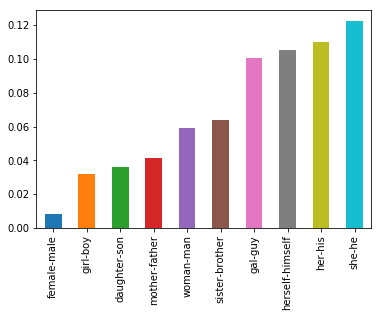

In [5]:
df_contrib = from_pair_to_contribution(Gender_Pair_10, model)
df = df_contrib.iloc[[2*i for i in range(10)],:].sort_values(by='CTR_1')
df['CTR_1'].plot(kind='bar')

In [10]:
df_contrib.sum().sum()

4.0404253

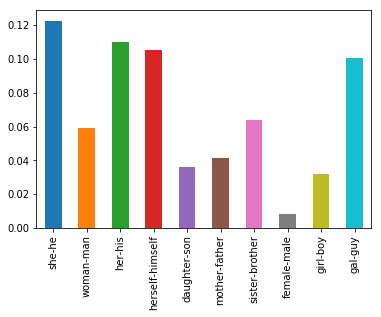

In [63]:
df['CTR_1'].plot(kind='bar')

#### 2.5 Robustness via the word pairs

In [22]:
Gender_Pair = [['she','he'],['woman','man'],
               ['her','his'],['Mary','John'],
               ['herself','himself'],['daughter','son'],
               ['mother','father'],['gal','guy'],
               ['sister','brother'],#['female','male'],
               ['girl','boy'], ['spokeswoman','spokesman'],
               ['stepmother','stepfather'],['queen','king'],
               ['actress','actor'],['girlfriend','boyfriend' ],
               ['twin_sister','twin_brother']]

def example1(Gender_Pair,word, model):
    ex = pd.DataFrame(data={'Mots':word})
    for i in range(2,len(Gender_Pair)+1):
        Pair = Gender_Pair[:i]
        direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
        B= []
        for w in word :
            B.append(lib.cosine_similarity(direction_g2,model[w])*100)
        ex[str(i)+'; add'+str(Gender_Pair[i-1])] = B
    ex ['mean']  = ex.mean(axis=1) 
    ex ['std']  = ex.std(axis=1) 
    ex['std/mean']=ex ['std']/ex ['mean']*100
    return(ex)
        
print('##################################') 
print('#   model 2  with Gender_Pair 10 #') 
print('##################################')
ex=example1(Gender_Pair_10,word, model)
ex

##################################
#   model 2  with Gender_Pair 10 #
##################################


,Mots,"2; add['woman', 'man']","3; add['her', 'his']","4; add['herself', 'himself']","5; add['daughter', 'son']","6; add['mother', 'father']","7; add['sister', 'brother']","8; add['female', 'male']","9; add['girl', 'boy']","10; add['gal', 'guy']",mean,std,std/mean
0,table,0.303398,0.922049,-0.620649,1.003083,1.489535,1.667020,1.796932,1.911242,0.041501,0.946012,0.827335,87.455018
1,apple,3.879755,4.513443,-3.755896,3.464881,3.739969,2.110251,1.959038,1.456219,1.291908,2.073285,2.331360,112.447646
2,engineer,-11.256249,-10.217709,10.143357,-11.016262,-12.637264,-12.881507,-13.004909,-12.891471,-11.437271,-9.466587,6.996559,-73.907928
3,woman,35.137478,38.075319,-37.060136,37.165880,38.243636,36.588299,36.302197,36.319584,33.136111,28.212041,23.123096,81.961798
4,student,13.915624,14.822863,-13.841997,14.202495,14.580609,13.550256,13.375795,13.448274,10.851127,10.545005,8.689828,82.407050
5,art,6.441233,7.142808,-6.826150,7.088884,7.171902,7.486591,7.470904,7.270625,6.592824,5.537736,4.384139,79.168448
6,mathematics,-2.647706,-1.253700,1.397137,-0.774383,-0.679699,-0.191139,-0.188910,0.181678,-0.736503,-0.543692,1.031882,-189.791701
7,music,3.826651,5.272703,-5.228924,5.181223,4.586204,4.061215,3.869979,4.025783,4.245131,3.315552,3.062805,92.376929
8,football,-22.388805,-19.968618,19.445023,-19.740769,-19.605254,-19.859600,-19.978443,-19.567254,-21.507446,-15.907907,12.532682,-78.782719
9,skirt,24.468927,25.571230,-25.562829,26.075771,25.654823,24.881136,25.075915,25.726992,25.548887,19.715650,16.015009,81.229930


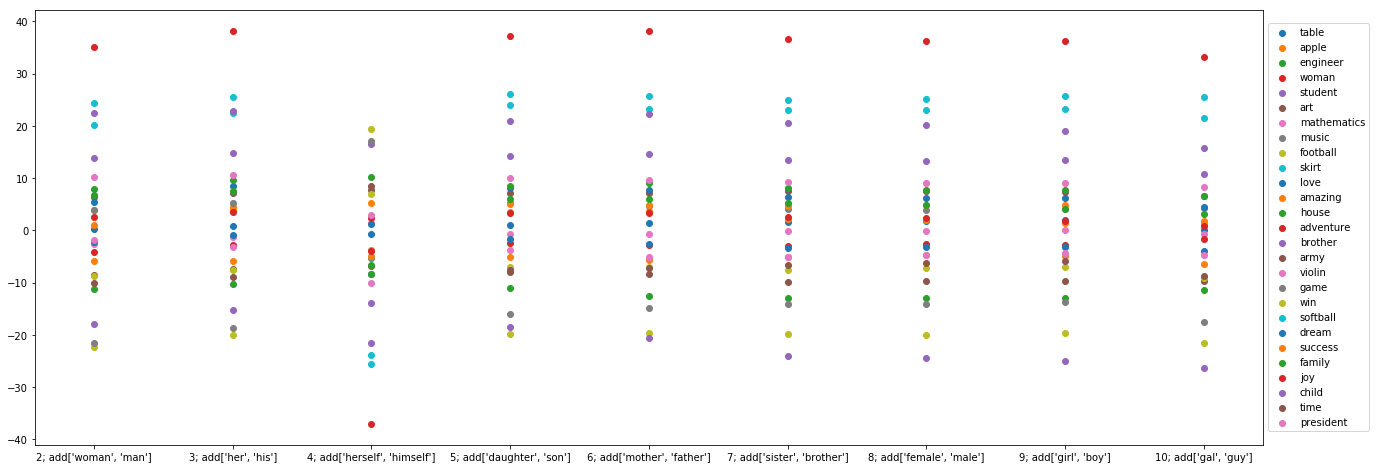

In [23]:
fin =ex.iloc[:,:-3]
plt.figure(figsize=(22,8))
#x = np.linspace(0,len(fin)-1,9)
name = fin.columns[1:]
for i in range(len(fin)):
    plt.scatter(name,fin.iloc[i,1:].values,label = fin.iloc[i,0])
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          #ncol=5, fancybox=True, shadow=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [24]:
def example1_reverse(Gender_Pair,word, model):
    ex = pd.DataFrame(data={'Mots':word})
    Gender_Pair =Gender_Pair[::-1]
    for i in range(1,len(Gender_Pair)+1):
        Pair = Gender_Pair[:i]
        #print(Pair)
        direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
        B= []
        for w in word :
            B.append(lib.cosine_similarity(direction_g2,model[w])*100)
        ex[str(i)+'; add'+str(Gender_Pair[i-1])] = B
    ex ['mean']  = ex.mean(axis=1) 
    ex ['std']  = ex.std(axis=1) 
    ex['std/mean']=ex ['std']/ex ['mean']*100
    return(ex)
        
print('#####################################') 
print('#   model 2 with gender_pair_10 inv #') 
print('#####################################')
ex=example1_reverse(Gender_Pair_10,word, model)
ex


#####################################
#   model 2 with gender_pair_10 inv #
#####################################


,Mots,"1; add['gal', 'guy']","2; add['girl', 'boy']","3; add['female', 'male']","4; add['sister', 'brother']","5; add['mother', 'father']","6; add['daughter', 'son']","7; add['herself', 'himself']","8; add['her', 'his']","9; add['woman', 'man']","10; add['she', 'he']",mean,std,std/mean
0,table,-7.783411,-6.723670,-6.187702,-3.975206,-2.359260,-1.202819,-0.838642,-0.124975,0.015990,0.041493,-2.913820,2.875925,-98.699474
1,apple,0.265735,-0.578166,-0.844516,-3.361287,-2.239583,-2.127534,-1.338248,0.153698,0.255925,1.291908,-0.852207,1.350740,-158.499020
2,engineer,-1.537944,-2.662922,-3.323024,-6.097433,-9.633528,-11.268179,-11.466308,-11.174326,-11.109927,-11.437265,-7.971086,3.907116,-49.016112
3,woman,8.804845,12.338360,12.729572,15.755901,20.778741,22.947159,26.615414,31.126276,32.377443,33.136091,21.660980,8.543553,39.442136
4,student,-3.620874,-1.630656,-1.454995,0.305495,2.943582,4.886647,6.714284,9.174728,9.732294,10.851115,3.790162,4.985903,131.548556
5,art,1.536199,1.841545,2.013510,3.941889,4.647046,5.349538,5.698290,6.433149,6.497864,6.592821,4.455185,1.913458,42.949002
6,mathematics,-4.323504,-3.222818,-3.102111,-1.442403,-1.071428,-0.011039,-0.341728,-0.005223,-0.444537,-0.736504,-1.470129,1.455163,-98.981965
7,music,3.760042,4.247177,3.884148,3.060701,2.347867,2.482462,3.157002,4.214984,4.027171,4.245129,3.542668,0.690870,19.501407
8,football,-22.376332,-22.009790,-22.346401,-22.535205,-22.070159,-21.964493,-21.525194,-20.675361,-21.268359,-21.507448,-21.827874,0.549189,-2.515998
9,skirt,16.295539,19.263704,20.122866,20.526893,20.855626,22.072965,23.670322,25.126183,25.544590,25.548884,21.902757,2.909706,13.284658


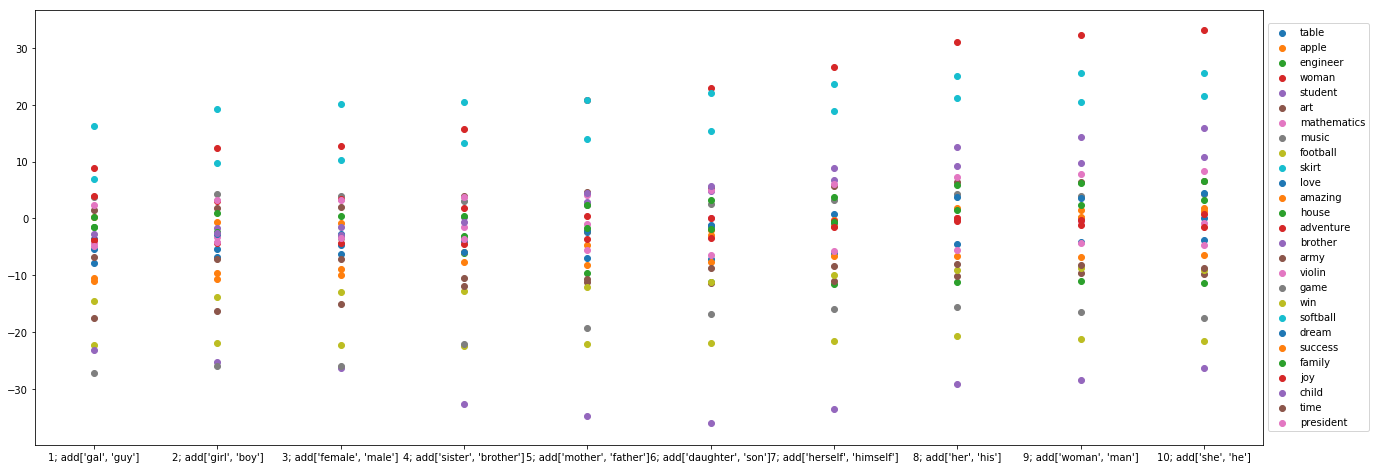

In [25]:
fin= ex.iloc[:,:-3]
plt.figure(figsize=(22,8))
#x = np.linspace(0,len(fin)-1,9)
name = fin.columns[1:]
for i in range(len(fin)):
    plt.scatter(name,fin.iloc[i,1:].values,label = fin.iloc[i,0])
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          #ncol=5, fancybox=True, shadow=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [26]:
from random import shuffle
def example1_shuffle(Gender_Pair,word, model):
    ex = pd.DataFrame(data={'Mots':word})
    shuffle(Gender_Pair)
    for i in range(1,len(Gender_Pair)+1):
        Pair = Gender_Pair[:i]
        #print(Pair)
        direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
        B= []
        for w in word :
            B.append(lib.cosine_similarity(direction_g2,model[w])*100)
        ex[str(i)+'; add'+str(Gender_Pair[i-1])] = B
    ex ['mean']  = ex.mean(axis=1) 
    ex ['std']  = ex.std(axis=1) 
    ex['std/mean']=ex ['std']/ex ['mean']*100
    return(ex)
        
print('#########################################') 
print('#   model 2 with gender_pair_10 shuffle #') 
print('#########################################')
ex=example1_shuffle(Gender_Pair_10,word, model)
ex


#########################################
#   model 2 with gender_pair_10 shuffle #
#########################################


,Mots,"1; add['girl', 'boy']","2; add['gal', 'guy']","3; add['woman', 'man']","4; add['mother', 'father']","5; add['herself', 'himself']","6; add['daughter', 'son']","7; add['sister', 'brother']","8; add['she', 'he']","9; add['female', 'male']","10; add['her', 'his']",mean,std,std/mean
0,table,-2.936488,-6.723670,-5.190153,-3.539522,-2.412979,1.558891,-0.788459,-0.580621,-0.410479,0.041503,-2.098198,2.421856,-115.425551
1,apple,5.469706,-0.578166,-0.379375,0.551260,0.855852,-0.756877,-0.918866,0.507985,0.384595,1.291906,0.642802,1.754778,272.988883
2,engineer,8.290212,-2.662922,-4.527255,-8.236531,-9.367795,10.644809,-11.221868,-11.701545,-11.847652,-11.437271,-5.206782,7.925601,-152.216885
3,woman,-28.136957,12.338360,19.580448,24.571337,28.960139,-30.012232,28.945598,30.754226,30.584058,33.136103,15.072108,22.838265,151.526679
4,student,-11.319073,-1.630655,1.897216,4.456937,6.959467,-8.153506,7.805769,9.579505,9.484102,10.851126,2.993089,7.348226,245.506455
5,art,-2.840677,1.841545,3.018607,3.807765,4.648881,-5.185042,5.868989,6.146950,6.154871,6.592824,3.005471,3.831681,127.490169
6,mathematics,-5.034921,-3.222819,-3.423559,-2.953571,-2.613683,1.686315,-0.841985,-1.112184,-1.090511,-0.736500,-1.934342,1.792124,-92.647730
7,music,-5.222942,4.247175,4.053231,3.314970,3.872566,-3.898295,3.284303,3.692406,3.511963,4.245132,2.110051,3.364241,159.438859
8,football,9.374171,-22.009790,-23.686266,-23.390576,-22.507612,22.467035,-22.090614,-22.363827,-22.433570,-21.507442,-14.814849,15.655664,-105.675484
9,skirt,-28.332552,19.263707,22.329196,22.811268,24.610537,-25.329247,24.166760,24.641696,24.843627,25.548890,13.455388,20.225584,150.315872


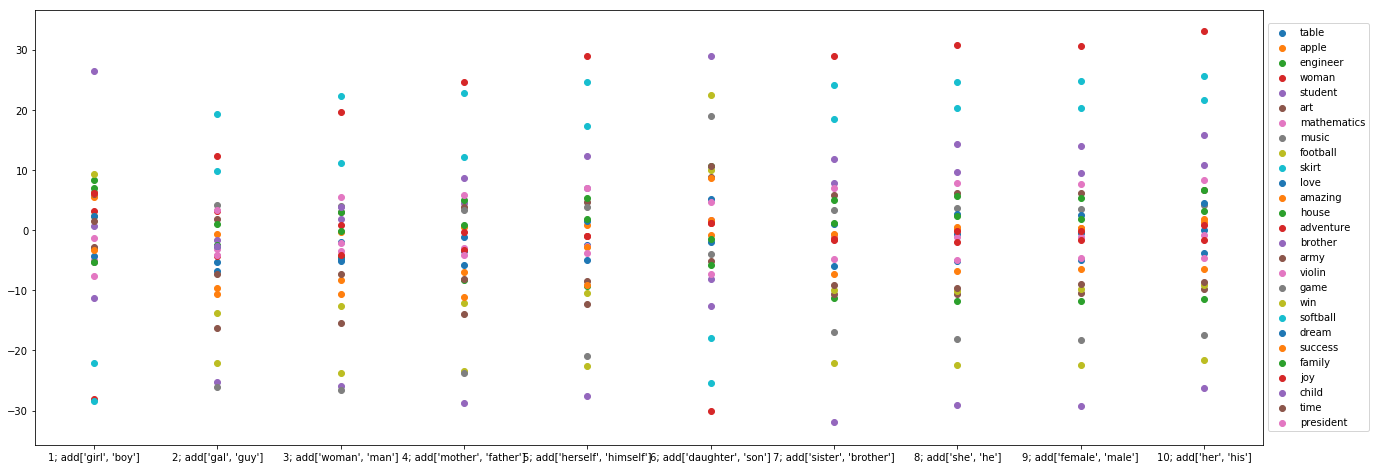

In [27]:
fin =ex.iloc[:,:-3]
plt.figure(figsize=(22,8))
#x = np.linspace(0,len(fin)-1,9)
name = fin.columns[1:]
for i in range(len(fin)):
    plt.scatter(name,fin.iloc[i,1:].values,label = fin.iloc[i,0])
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          #ncol=5, fancybox=True, shadow=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

#### Comment :
We obseve that some pairs of words have really huge impact on the direct biais evaluation, for instance 'girl' and 'boy' change the sign of the direct biais.I do not have any explanation for this phenomenon for now. Let's obserse the mean and the standard deviation if we took the absolute value.

In [28]:
def example1_abs(Gender_Pair,word, model):
    ex = pd.DataFrame(data={'Mots':word})
    for i in range(2,len(Gender_Pair)+1):
        Pair = Gender_Pair[:i]
        direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
        B= []
        for w in word :
            B.append(abs(lib.cosine_similarity(direction_g2,model[w])*100))
        ex['direction with '+str(i)+' pairs, last:'+str(Gender_Pair[i-1])] = B
    ex ['mean']  = ex.mean(axis=1) 
    ex ['std']  = ex.std(axis=1) 
    ex['std/mean']=ex ['std']/ex ['mean']*100
    return(ex)
        
print('###################') 
print('#   model 2, abs  #') 
print('###################')
ex=example1_abs(Gender_Pair_10,word, model)
ex

###################
#   model 2, abs  #
###################


,Mots,"direction with 2 pairs, last:['gal', 'guy']","direction with 3 pairs, last:['woman', 'man']","direction with 4 pairs, last:['mother', 'father']","direction with 5 pairs, last:['herself', 'himself']","direction with 6 pairs, last:['daughter', 'son']","direction with 7 pairs, last:['sister', 'brother']","direction with 8 pairs, last:['she', 'he']","direction with 9 pairs, last:['female', 'male']","direction with 10 pairs, last:['her', 'his']",mean,std,std/mean
0,table,6.723670,5.190153,3.539522,2.412979,1.558891,0.788459,0.580621,0.410479,0.041503,2.360697,2.208550,93.554961
1,apple,0.578166,0.379375,0.551260,0.855852,0.756877,0.918866,0.507985,0.384595,1.291906,0.691654,0.279140,40.358308
2,engineer,2.662922,4.527255,8.236531,9.367795,10.644809,11.221868,11.701545,11.847652,11.437271,9.071961,3.159209,34.823882
3,woman,12.338360,19.580448,24.571337,28.960139,30.012232,28.945598,30.754226,30.584058,33.136103,26.542500,6.283316,23.672662
4,student,1.630655,1.897216,4.456937,6.959467,8.153506,7.805769,9.579505,9.484102,10.851126,6.757587,3.170065,46.911200
5,art,1.841545,3.018607,3.807765,4.648881,5.185042,5.868989,6.146950,6.154871,6.592824,4.807275,1.530718,31.841692
6,mathematics,3.222819,3.423559,2.953571,2.613683,1.686315,0.841985,1.112184,1.090511,0.736500,1.964570,1.024566,52.152203
7,music,4.247175,4.053231,3.314970,3.872566,3.898295,3.284303,3.692406,3.511963,4.245132,3.791116,0.345155,9.104322
8,football,22.009790,23.686266,23.390576,22.507612,22.467035,22.090614,22.363827,22.433570,21.507442,22.495192,0.633975,2.818269
9,skirt,19.263707,22.329196,22.811268,24.610537,25.329247,24.166760,24.641696,24.843627,25.548890,23.727214,1.875498,7.904417


####  Lets do some combbanation of the 6 first pairs of words


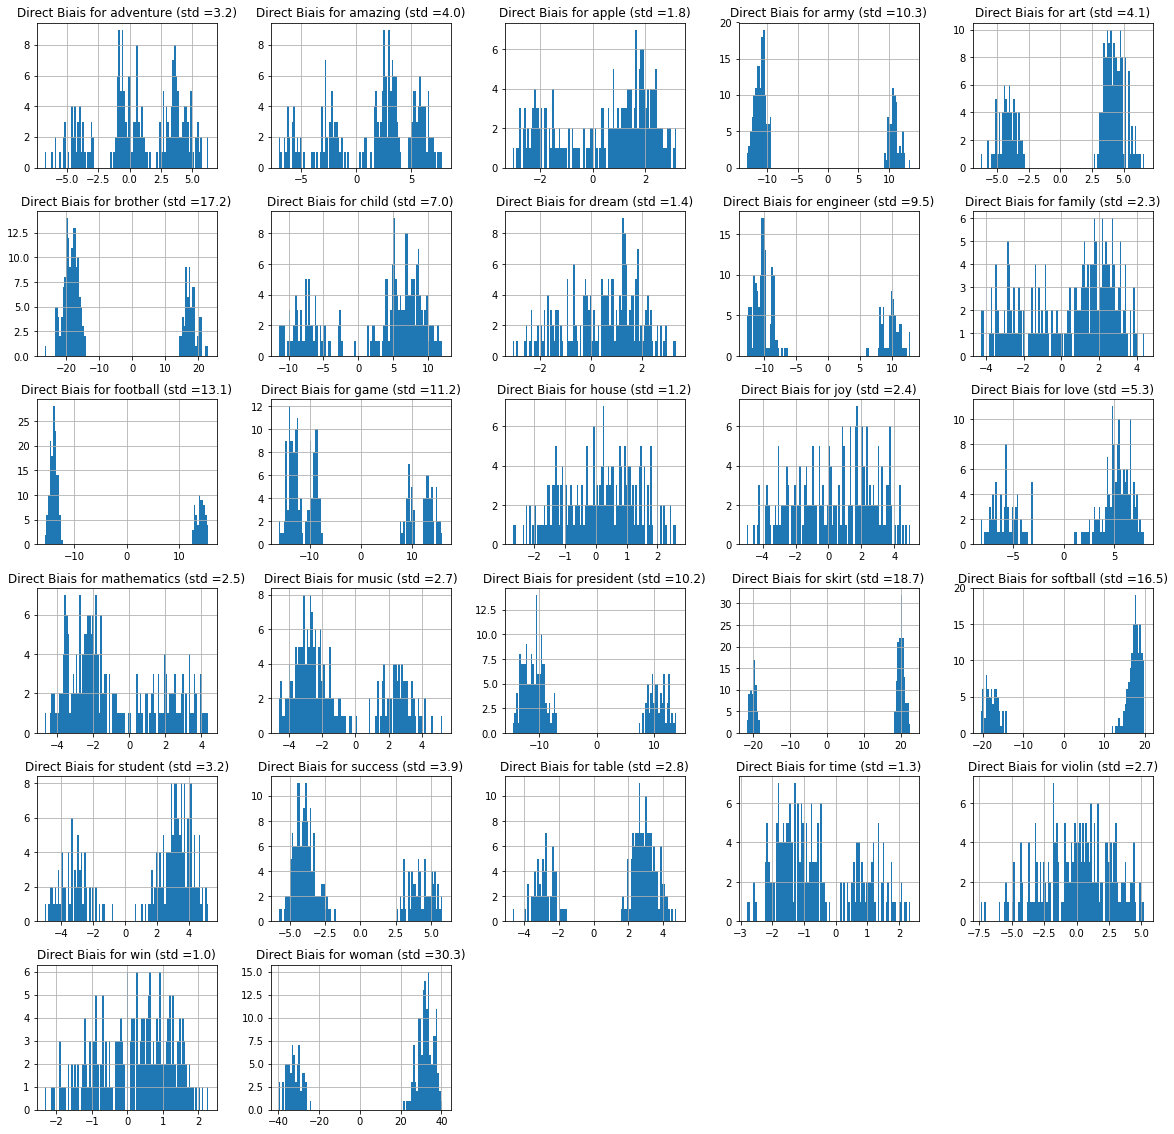

In [29]:
def dist_combanation(word,Gender_Pair,model):
    df_B=pd.DataFrame(data={'Pair':list(itertools.combinations(Gender_Pair,6))})
    for w in word:
        B=[]
        for Pair in itertools.combinations(Gender_Pair,6):
            direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
            B.append(lib.cosine_similarity(direction_g2,model[w])*100)
            
        df_B['Direct Biais for '+str(w)+' (std ='+str(round(np.std(B),1))+')']=B
    return(df_B)
df_B = dist_combanation(word,Gender_Pair_10,model_ff)  

df_B.hist(bins=100,grid=True,figsize=(20,20))
plt.show()

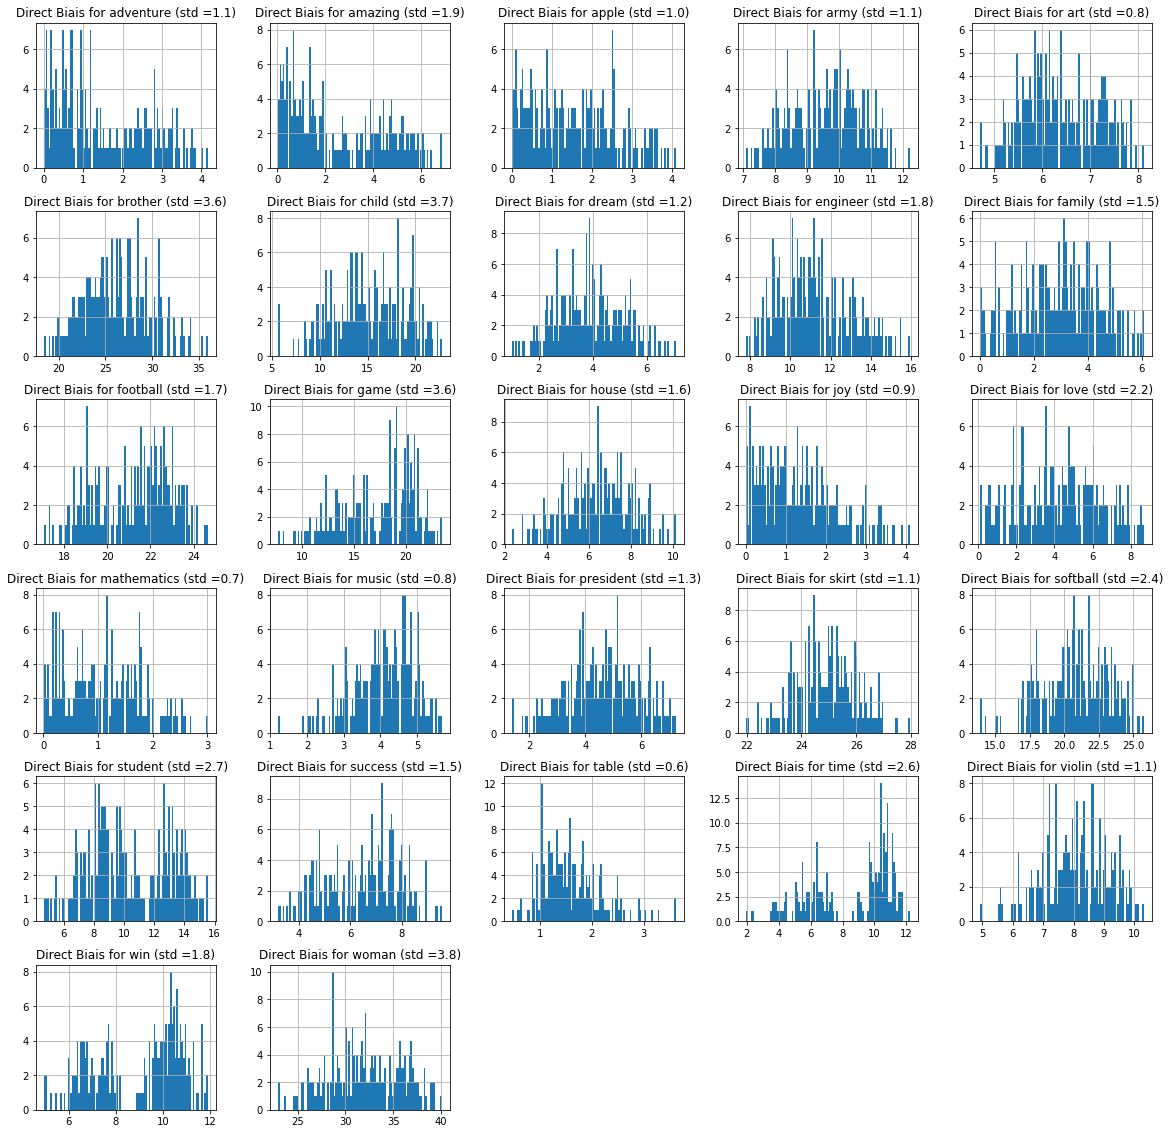

In [30]:
def dist_combanation_abs(word,Gender_Pair,model):
    df_B=pd.DataFrame(data={'Pair':list(itertools.combinations(Gender_Pair,6))})
    for w in word:
        B=[]
        for Pair in itertools.combinations(Gender_Pair,6):
            direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
            B.append(abs(lib.cosine_similarity(direction_g2,model[w])*100))
            
        df_B['Direct Biais for '+str(w)+' (std ='+str(round(np.std(B),1))+')']=B
    return(df_B)
df_B = dist_combanation_abs(word,Gender_Pair_10,model)  

df_B.hist(bins=100,grid=True,figsize=(20,20))
plt.show()

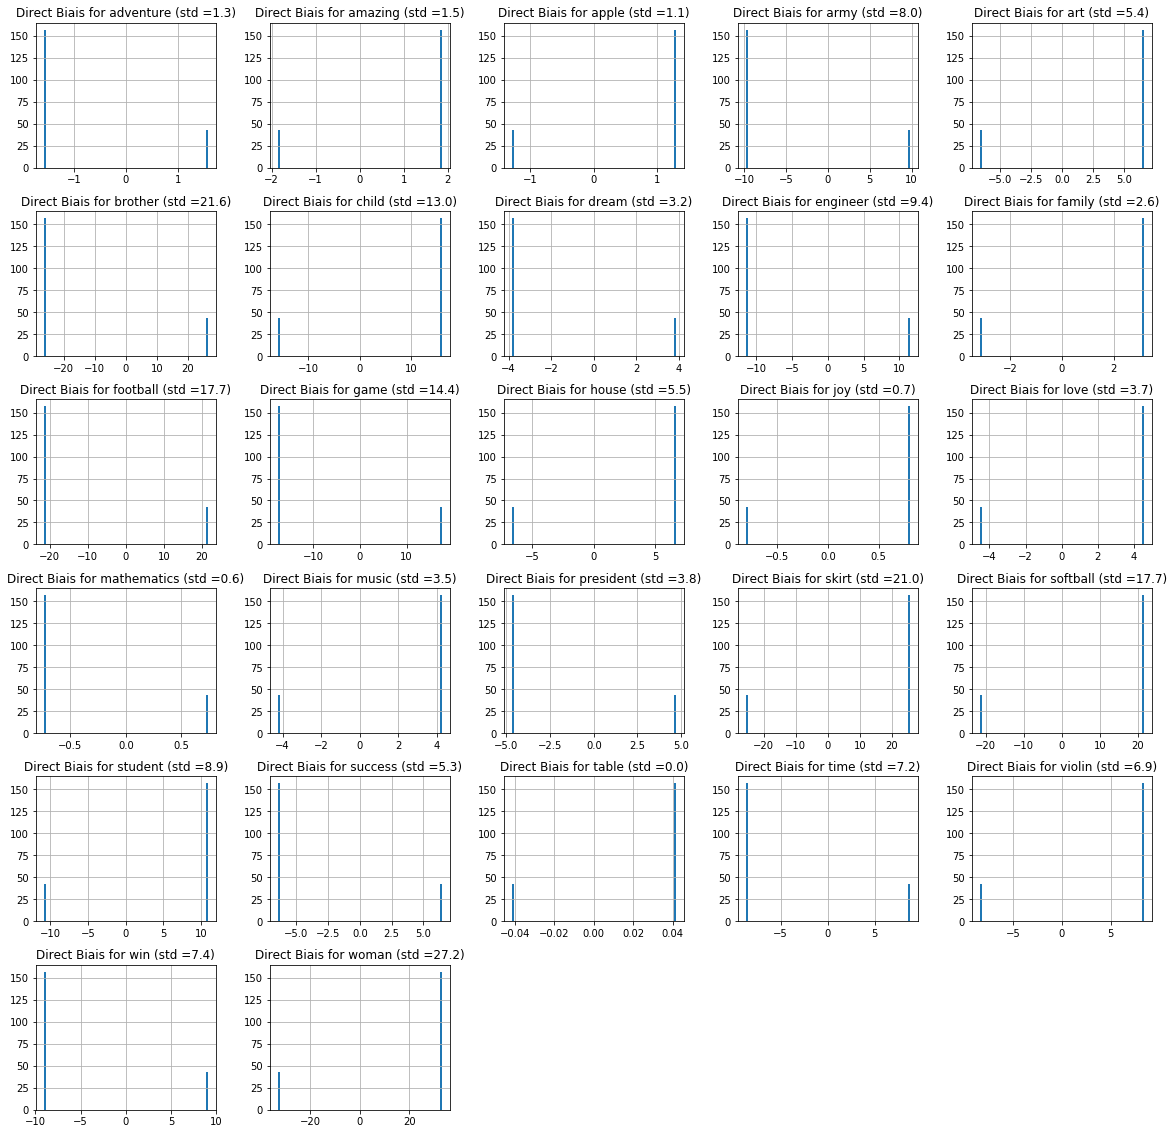

In [31]:
def dist_combanation_rand(word,Gender_Pair,model):
    import random
    GP = []
    for i in range(200):
        GP.append(random.sample(Gender_Pair, len(Gender_Pair)))
    df_B=pd.DataFrame(data={'Pair':list(GP)})
    for w in word:
        B=[]
        for Pair in GP:
            direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
            B.append(lib.cosine_similarity(direction_g2,model[w])*100)
            
        df_B['Direct Biais for '+str(w)+' (std ='+str(round(np.std(B),1))+')']=B
    return(df_B)
df_B = dist_combanation_rand(word,Gender_Pair_10,model)  

df_B.hist(bins=100,grid=True,figsize=(20,20))
plt.show()

## Comment :
As we were expected, the biais is not independant from the combination of 6 pairs we are taking. 

## Does the differences observe reveal important differences in terms of direction ? 
We are going to compute the the cosine similarity for all the direction with the first one as the origine for all the combination of 6 elements.


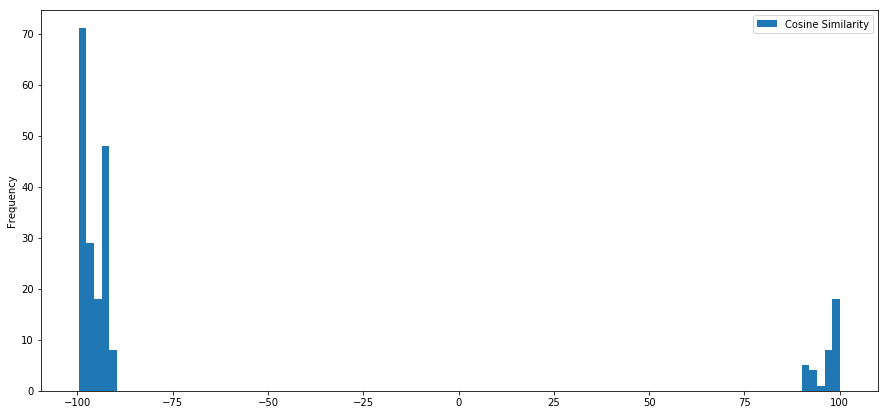

In [43]:
def dist_cos_dir(k,Gender_Pair,model):
    df_B=pd.DataFrame(data={'Pair':list(itertools.combinations(Gender_Pair,k))})
    direction_g0, expl_var_g0,eig_values_g0 = from_pair_to_direction2(Gender_Pair[:k], model)
    B=[]
    for Pair in itertools.combinations(Gender_Pair,k):
            direction_g2, expl_var_g2,eig_values_g2 = from_pair_to_direction2(Pair, model)
            B.append(lib.cosine_similarity(direction_g2,direction_g0)*100)
    df_B['Cosine Similarity']=B
    return(df_B)
df_B = dist_cos_dir(6,Gender_Pair_10,model)
df_B.plot(kind='hist',bins=100,figsize=(15,7))
plt.show()


In [45]:
def changing_pair(Gender_Pair, model1,model2):
    W2V = []
    FF = []
    I=[]
    for i in range(1,len(Gender_Pair)+1):
        Pair = Gender_Pair[:i]
        db1 = Direct_Biais(list(model1.vocab), Pair, model1)
        W2V.append(db1)
        db2 = Direct_Biais(list(model2.vocab), Pair, model2)
        FF.append(db2)
        I.append('direction with '+str(i)+' pairs, last:'+str(Gender_Pair[i-1]))
    I.append('std')
    W2V.append(np.std(W2V))
    FF.append(np.std(FF))
    ex = pd.DataFrame(data={'Word2Vect':W2V,'FastText':FF},index=I)
    return(ex)
cg = changing_pair(Gender_Pair_10, model,model_ff)
cg 

StopIteration: 

StopIteration: 

## 2) Indirect Biais

In [33]:
def projection(w,direction):
    """
    return the projection of w on the vector "direction"
    """
    return(np.dot(direction,np.dot(direction,w)))

def indirect_biais(w1,w2,direction):
    """
    return the indirect Biais
    
    """
    
    w1_t = w1-projection(w1,direction)
    w2_t = w2-projection(w2,direction)
    norm= np.linalg.norm(w1)* np.linalg.norm(w2)
    norm_t = np.linalg.norm(w1_t)* np.linalg.norm(w2_t)
    return((np.dot(w1, w2)-np.dot(w1_t,w2_t)/norm_t)/norm)
    

In [34]:
print(indirect_biais(model['softball'],model['waitress'],direction_g2))
print(indirect_biais(model['football'],model['waitress'],direction_g2))

0.056675553
-0.07357938


In [35]:
print(indirect_biais(model['softball'],model['homemaker'],direction_g2))
print(indirect_biais(model['football'],model['homemaker'],direction_g2))

0.059493244
-0.07536873


In [36]:
print(indirect_biais(model['softball'],model['divorce'],direction_g2))
print(indirect_biais(model['football'],model['divorce'],direction_g2))

0.02232347
-0.025783189


In [37]:
print(indirect_biais(model['softball'],model['cocky'],direction_g2))
print(indirect_biais(model['football'],model['cocky'],direction_g2))

-0.04831314
0.036826923
